# Data Masters Case: Exploração inicial

Felipe Viacava -- São Paulo, ago/2023

## Bibliotecas

In [1]:
# --- Data Exploration --- #
import pandas as pd
import missingno as mno

# --- Plots --- #
import matplotlib.pyplot as plt

# --- Data Leakaged Avoidance --- #
from sklearn.model_selection import train_test_split

# --- Custom Transformers --- #
from resources.customtransformers import \
    DropConstantColumns, \
    DropDuplicateColumns, \
    AddNonZeroCount

# --- Custom EDA Support Functions --- #
from resources.edautils import neg_pos_zero

In [2]:
# --- Setting Global Options --- #
pd.options.display.max_columns = None

## Separação em treino e teste

Para evitar todo e qualquer vazamento de dados e testar os modelos da forma mais semelhante de uma aplicação real possível, o primeiro passo foi separar os datasets em treino e testes e armazená-los para que possam ser usados nos próximos notebooks sem a necessidade de realizar este passo novamente.

In [3]:
df = pd.read_csv("data/raw.csv")

train, test = train_test_split(df, stratify=df["TARGET"], random_state=42, train_size=.8)

train.to_csv("data/train.csv")
test.to_csv("data/test.csv")

df = train
del train, test

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

## Removendo colunas constantes e duplicadas

Este processo foi estruturado em formas de classe para uso em Pipelines e Column Transformers do sklearn. Aqui foram usados apenas para limpar o dataset e tornar a análise exploratória mais curta.

In [4]:
dcc = DropConstantColumns(print_cols=True)
dcc = dcc.fit(df)
df = dcc.transform(df)

47 constant columns were found


In [5]:
ddc = DropDuplicateColumns(print_cols=True)
ddc = ddc.fit(df)
df = ddc.transform(df)

25 duplicate columns were found.


## Análise Exploratória

Nesta etapa, são determinadas algumas premissas para o tratamento das variáveis do nosso conjunto de dados. As variáveis foram separadas em grupos com base nos prefixos de seus nomes. Cada grupo teve suas premissas -- assim como a análise de dados faltantes, que a priori não existem -- descritas em sua respectiva seção.

In [6]:
df \
    .isna() \
    .sum() \
    .reset_index() \
    .rename(
        mapper={
            "index":"Column",
            0:"Null Values"
        },
        axis=1
    ) \
    .nlargest(5,"Null Values")

,Column,Null Values
0,ID,0
1,var3,0
2,var15,0
3,imp_ent_var16_ult1,0
4,imp_op_var39_comer_ult1,0


### ID

ID: Assumiu-se que esta coluna é o ID anonimizado de cada observação (cliente) da base, tanto pelo nome quanto por não conter nenhum valor duplicado.

In [7]:
df["ID"] \
    .value_counts() \
    .reset_index() \
    .nlargest(5, "count") \
    .set_index("ID")

,count
ID,
111813,1
135016,1
90436,1
70100,1
116087,1


### TARGET

TARGET: Assumiu-se que esta coluna é a variável que se deseja predizer, tanto pelo nome quanto por ser binária.

In [8]:
df["TARGET"] \
    .value_counts(normalize=True) \
    .reset_index() \
    .set_index("TARGET")

,proportion
TARGET,
0,0.960438
1,0.039562


### Saldo

Prefixo "saldo": num contexto de mercado financeiro, assumiu-se que estas são variáveis numéricas (saldo em conta, saldo em atraso, saldo em linha de crédito, etc).

Existem pouquíssimos valores negativos nestas colunas, o que nos poderia levar a entender que se tratam de valores faltantes. Aqui, optou-se por manter os valores originais, uma vez que saldo em conta pode ser negativo (cheque especial, por exemplo).

Um único valor se mostrou estranho: -4942.26, que aparece mais de uma vez como o valor mínimo da coluna, não havendo em nenhum das colunas de prefixo "saldo" um valor inferior a este -- não se escolheu considerá-los como nulos pois este valor pode ser determinado alguma política do banco.

Verificou-se, também, que este subconjunto é muito esparso (muitas colunas preenchidas quase que completamente por 0s). Foi criada uma classe para adicionar uma coluna com a contagem de valores diferentes de 0 deste subconjunto. Esta variável poderia agregar informação ao modelo pois, se estas variáveis majoritariamente preenchidas com 0 representarem algum tipo de saldo em atraso ou produtos preventivos, a contagem traz alguma informação generalizada sobre o relacionamento deste cliente com o banco.

In [9]:
saldo_cols = [
    col
    for col in df.columns
    if col.startswith("saldo")
]

df[saldo_cols].describe()

,saldo_var1,saldo_var5,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3
count,6.081600e+04,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000
mean,5.421243e+01,1023.580114,147.164810,6.145564e+03,5007.146940,1.556449e+03,6.563596e+03,73.400380,2.193110e+02,4.932912e+01,29.460104,6.042704e+03,77.008466,73.592049,0.518094,1.388042e+04,3.350655e+02,3.416418,8.024900,0.838595,37.824253,4.044708,7.316827e+03,107.729578,1574.486122,8.892026e+02,1084.740443,1056.020634,72.059624,9.595272,129.412427,113.547998,4.096795e+03,632.316635,5.827253e+03,4.479855e+03,3632.299539,563.873755,4867.817947,3869.127405,801.746822,165.940223,9.967677e+02,7.797536e+02,1.076352e+02,4.474321e+01,1.559413e+02,1.300591e+02,0.266339,0.002388,0.317384,0.233287,6.440666,1.311271,7.954414,5.865130,33.599873,1.668842,82.080819,61.958431
std,1.216651e+04,9631.082614,2638.277572,4.976986e+04,32708.177345,2.077014e+04,3.888554e+04,3051.818963,2.535943e+04,1.216501e+04,2748.430264,4.961221e+04,769.211470,755.560611,92.904907,6.467857e+04,2.601808e+04,131.023675,492.024186,158.144155,500.605840,109.663575,5.069721e+04,5733.602855,11921.458336,1.031913e+04,9390.625089,8065.251410,1870.405196,481.561337,2268.032588,1945.458121,3.961191e+04,9593.663815,4.789661e+04,3.649015e+04,26286.326792,7297.654879,31963.155279,25587.988788,13401.769748,4705.909949,1.661751e+04,1.279101e+04,1.719559e+04,9.627698e+03,1.670705e+04,1.461361e+04,46.756603,0.588786,58.225764,35.642179,416.720118,116.443347,488.355798,353.187991,2193.005808,140.817701,4381.968936,3106.016476
min,0.000000e+00,-1842.000000,-4942.260000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-4.942260e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-4.942260e+03,0.000000,-128.370000,-8.040000e+00,-922.380000,-476.070000,-287.670000,0.000000,-3401.340000,-1844.520000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-3.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [10]:
df[saldo_cols].describe().transpose()[["min"]].nsmallest(5, "min")

,min
saldo_var8,-4942.26
saldo_var30,-4942.26
saldo_var42,-4942.26
saldo_medio_var8_ult1,-3401.34
saldo_medio_var8_ult3,-1844.52


In [11]:
neg_pos_zero(df, saldo_cols)

,Column,Negative values (%),Positive values (%),Zero values (%)
0,saldo_var1,0.000000,0.358458,99.641542
33,saldo_medio_var12_hace3,0.000000,1.687056,98.312944
34,saldo_medio_var12_ult1,0.000000,4.589253,95.410747
35,saldo_medio_var12_ult3,0.000000,4.589253,95.410747
36,saldo_medio_var13_corto_hace2,0.000000,3.897001,96.102999
37,saldo_medio_var13_corto_hace3,0.000000,1.784070,98.215930
38,saldo_medio_var13_corto_ult1,0.000000,4.181465,95.818535
39,saldo_medio_var13_corto_ult3,0.000000,4.181465,95.818535
40,saldo_medio_var13_largo_hace2,0.000000,0.656077,99.343923
41,saldo_medio_var13_largo_hace3,0.000000,0.406143,99.593857


In [12]:
anzc_saldo = AddNonZeroCount(prefix="saldo")
anzc_saldo = anzc_saldo.fit(df)
df = anzc_saldo.transform(df)

### Imp

Prefixo "imp": num contexto de mercado financeiro -- entendendo que "Imp" se deriva de "Imposicion", ou seja, algum tipo de taxa --, assumiu-se que estas são variáveis numéricas

As caraterísticas deste subconjunto se assemelham muito às do subconjunto de prefixo "saldo". Optou-se por tomar as mesmas decisões, inclusiva a contagem de não-zeros (maior incidência de taxas pode discriminar o comportamento de um cliente?)

In [13]:
imp_cols = [
    col
    for col in df.columns
    if col.startswith("imp")
]

df[imp_cols].describe()

,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1
count,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.00000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,60816.000000,6.081600e+04
mean,81.239989,72.185307,119.169036,3.164183,5.748708,0.406672,0.566005,2.919893,69.021124,113.420328,67.706449,111.796809,137.324003,68.113121,112.362815,140.243896,4.13353,0.258021,0.022564,2848.155970,631.587649,1.197763e+02,34.288115,2.484215,0.034530,3.401817,1.480680e+02,11.881684,1.416635e+02,48.352820,0.197763,14.439225,870.980582,1.934909e+03,2.343510,3.140848,2.339529,3.067888,0.173346,0.049329,1.283605,9.881891e+01
std,1364.095864,338.049064,544.262724,86.245545,142.173207,32.490295,38.812040,92.048327,320.203951,514.898002,526.841213,849.182252,700.709527,530.960400,853.740784,715.611960,286.69313,63.630281,4.583333,25562.833133,11407.934951,2.472546e+04,2666.701966,207.221753,4.213975,619.668860,7.036092e+03,936.771518,1.522183e+04,3014.222511,48.770117,1206.329762,13961.760981,2.340013e+04,434.070579,569.043654,399.381114,346.953267,26.398397,12.165006,316.454762,1.260544e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
max,135000

In [14]:
df[imp_cols].describe().transpose()[["min"]].nsmallest(5, "min")

,min
imp_ent_var16_ult1,0.0
imp_op_var39_comer_ult1,0.0
imp_op_var39_comer_ult3,0.0
imp_op_var40_comer_ult1,0.0
imp_op_var40_comer_ult3,0.0


In [15]:
neg_pos_zero(df, imp_cols)

,Column,Negative values (%),Positive values (%),Zero values (%)
0,imp_ent_var16_ult1,0,4.760260,95.239740
23,imp_aport_var33_hace3,0,0.027953,99.972047
24,imp_aport_var33_ult1,0,0.008222,99.991778
25,imp_var7_emit_ult1,0,0.004933,99.995067
26,imp_var7_recib_ult1,0,0.281176,99.718824
27,imp_compra_var44_hace3,0,0.037819,99.962181
28,imp_compra_var44_ult1,0,0.116746,99.883254
29,imp_reemb_var13_ult1,0,0.050973,99.949027
30,imp_reemb_var17_hace3,0,0.001644,99.998356
31,imp_reemb_var17_ult1,0,0.024665,99.975335


In [16]:
anzc_imp = AddNonZeroCount(prefix="imp")
anzc_imp = anzc_imp.fit(df)
df = anzc_imp.transform(df)

### Delta

Prefixo "delta": diferentemente dos demais subconjuntos estudados até o momento, esta variável também aparenta ser contínua. Contudo, em 100% de suas colunas o valor máximo é 9999999999. Removendo estes valores, o maior valor encontrado considerando todas as colunas é 8. Assim, considerou-se que se tratam de valores faltantes. Foi criada uma classe para tratar estes valores no pipeline. A classe transforma estes valores em None, cria uma coluna com a contagem de None (não conhecer bem o cliente pode dizer algo sobre sua insatisfação?) e exclui as colunas resultantes que contenham apenas None ou 0.

In [17]:
delta_cols = [
    col
    for col in df.columns
    if col.startswith("delta")
]

df[delta_cols]

,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
56035,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
15449,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
68443,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
50258,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4858,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46587,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
27736,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
7406,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
69008,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_ = df.copy()
df_[delta_cols] = df_[delta_cols] \
    .applymap(lambda x: None if x == 9999999999 else x) #\
#    .applymap(lambda x: None if x == -1 else x)

In [19]:
df_[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,60815.0,60814.0,60523.000000,60782.000000,60815.000000,60757.000000,60785.0,60801.000000,60812.000000,60813.0,60813.000000,60815.0,60778.000000,60523.000000,60782.000000,60815.000000,60757.00000,60778.000000
mean,0.0,0.0,-0.021865,-0.000206,-0.000265,-0.000008,0.0,-0.000016,-0.000033,0.0,-0.000082,0.0,0.000073,-0.022091,-0.000230,-0.000222,0.00003,0.000115
std,0.0,0.0,0.151406,0.016350,0.015977,0.035928,0.0,0.004056,0.005735,0.0,0.009067,0.0,0.022345,0.147205,0.015175,0.014759,0.02945,0.032703
min,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,0.0,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,0.0,0.0,5.500000,1.500000,0.000000,6.267608,0.0,0.000000,0.000000,0.0,0.000000,0.0,5.417098,1.000000,0.000000,0.000000,4.00000,8.000000


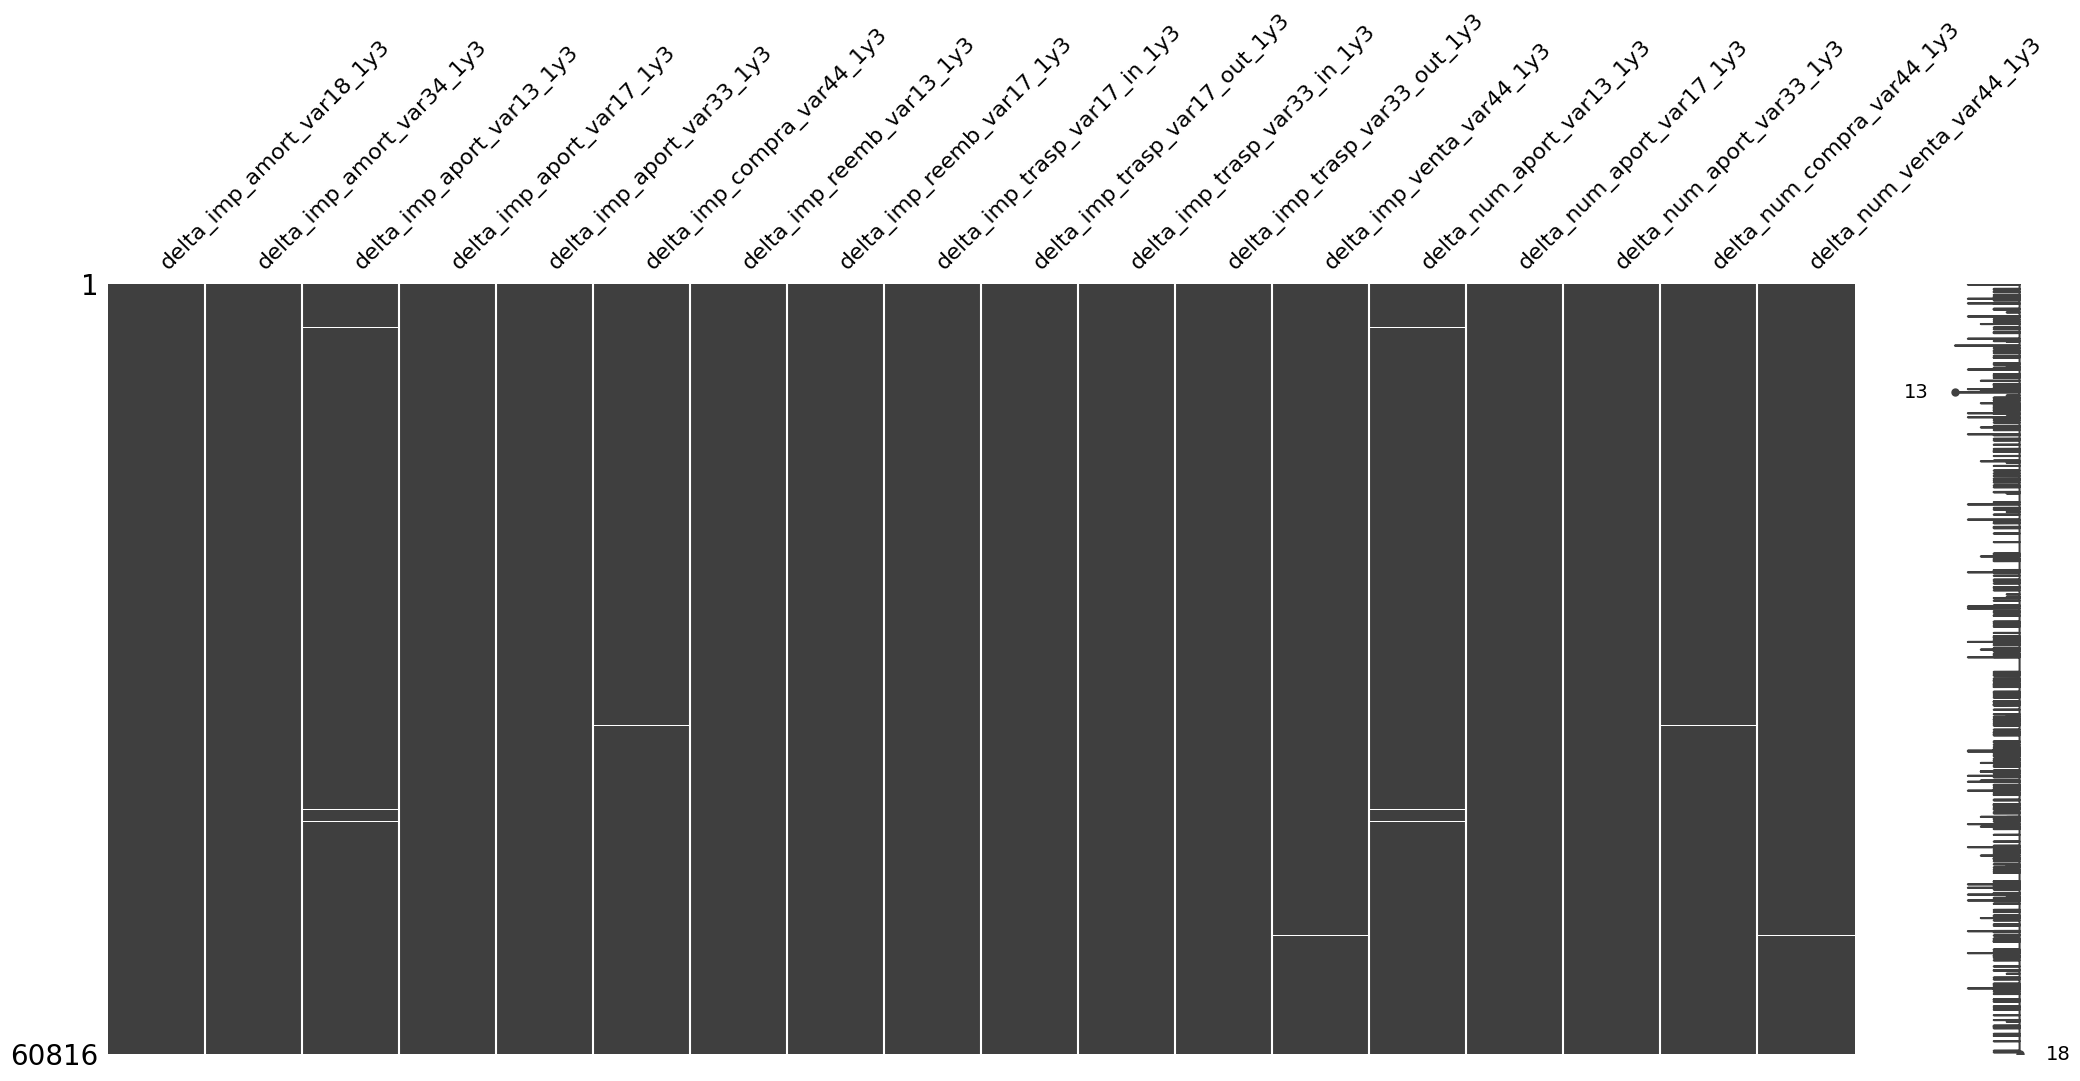

In [20]:
mno.matrix(df_[delta_cols])
plt.show()

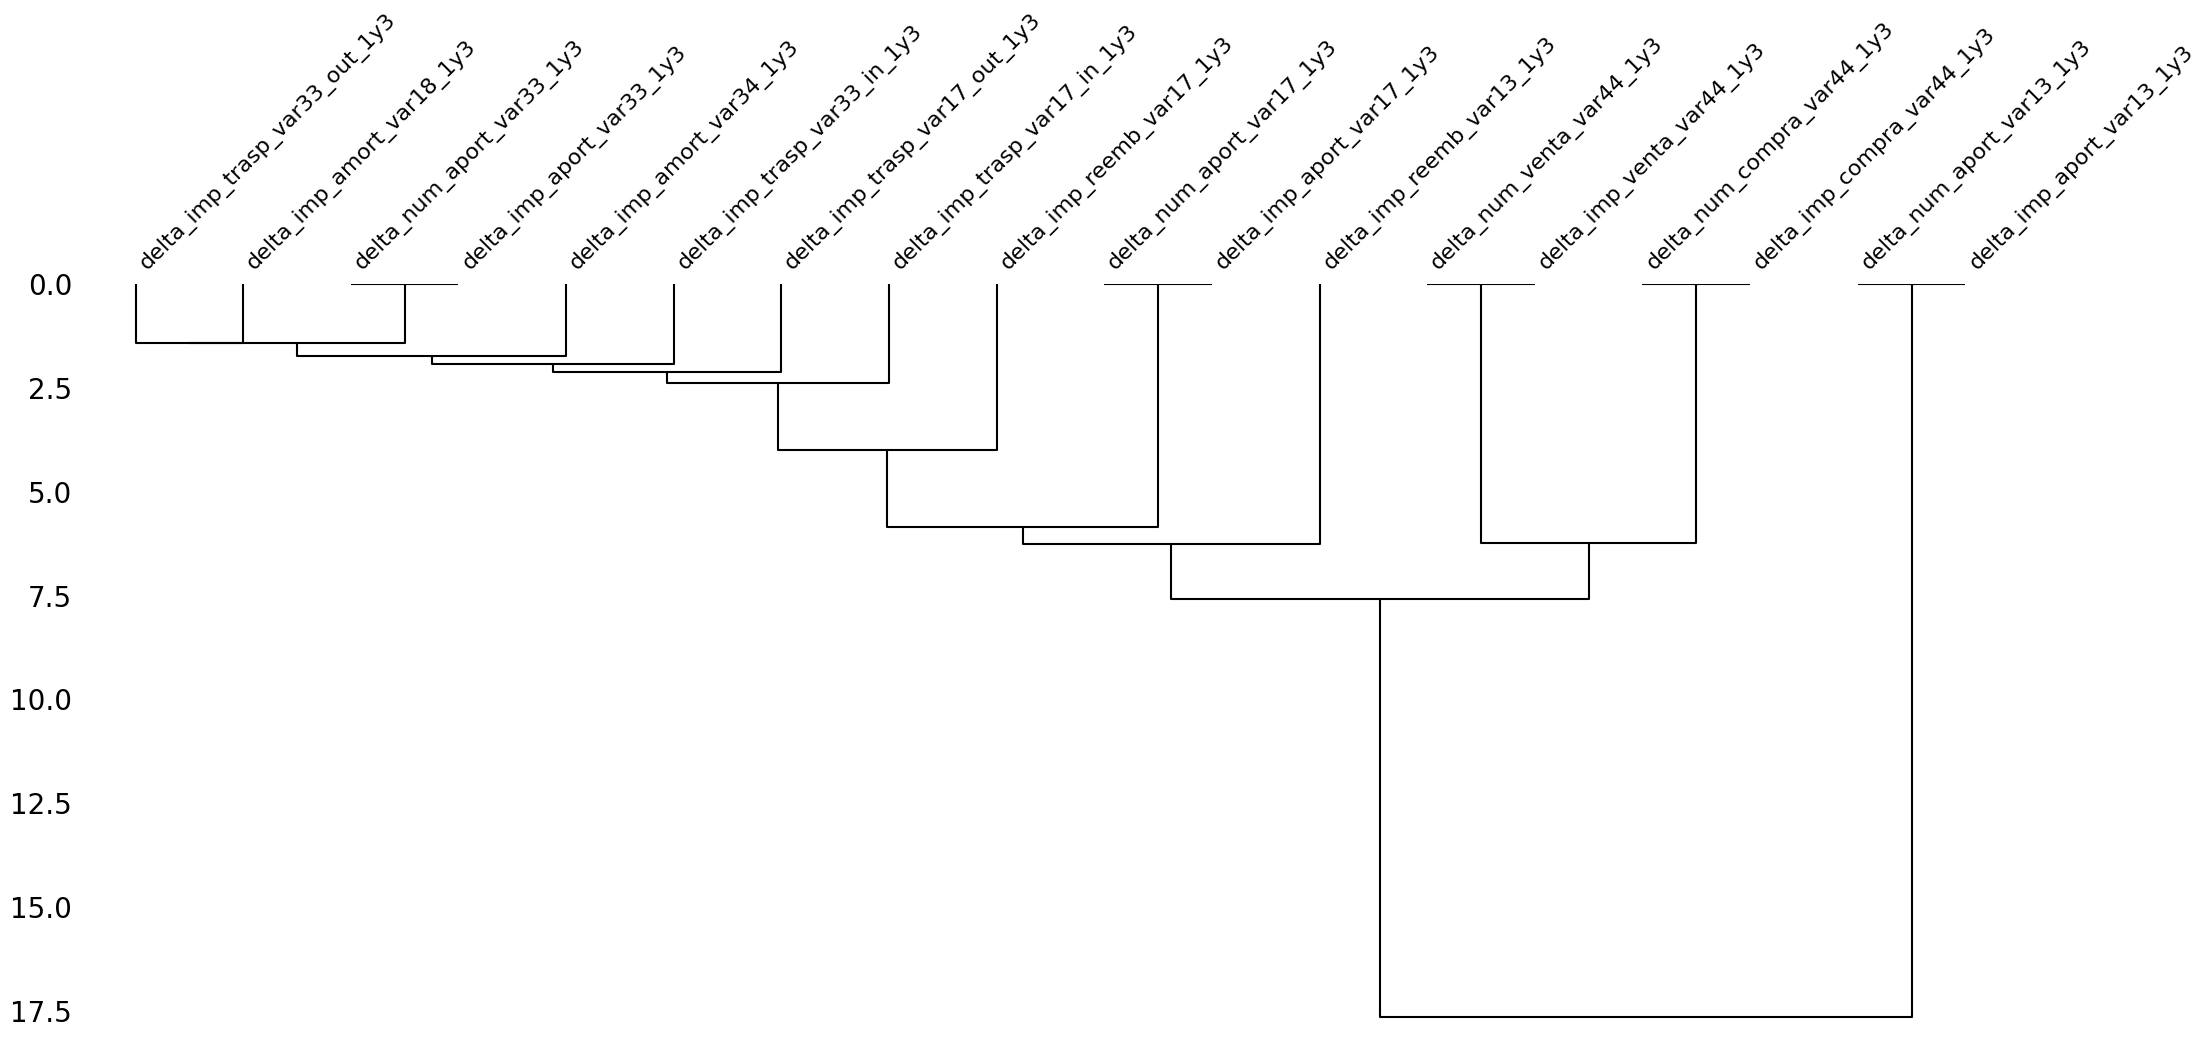

In [21]:
mno.dendrogram(df_[delta_cols])
plt.show()

In [22]:
df_[delta_cols] = df_[delta_cols] \
    .applymap(lambda x: None if x == -1 else x)

In [23]:
df_[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,60815.0,60814.0,59184.000000,60768.000000,60802.000000,60746.000000,60785.0,60800.0,60810.0,60813.0,60808.0,60815.0,60777.000000,59184.000000,60768.0,60802.000000,60746.000000,60777.000000
mean,0.0,0.0,0.000265,0.000025,-0.000051,0.000173,0.0,0.0,0.0,0.0,0.0,0.0,0.000089,0.000034,0.0,-0.000008,0.000211,0.000132
std,0.0,0.0,0.036146,0.006085,0.006447,0.033316,0.0,0.0,0.0,0.0,0.0,0.0,0.021973,0.005813,0.0,0.002028,0.026198,0.032450
min,0.0,0.0,-0.903846,0.000000,-0.950000,-0.978792,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.500000,-0.666667,0.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,0.0,0.0,5.500000,1.500000,0.000000,6.267608,0.0,0.0,0.0,0.0,0.0,0.0,5.417098,1.000000,0.0,0.000000,4.000000,8.000000


### Ind

Prefixo "ind": estas variáveis são compostas exclusivamente por valores de 0 e 1, ou seja, são variáveis binárias.

Neste caso, como as variáveis já são binarizadas, a análise é mais simples. Não há nenhum outlier que chame a atenção ou levante suspeitas de serem, na verdade, missing features. Assim, optou-se por não realizar nenhuma

In [26]:
ind_cols = [
    col
    for col in df.columns
    if col.startswith("ind")
]

df[ind_cols].describe().loc[["min", "max"]].transpose()

,min,max
ind_var1_0,0.0,1.0
ind_var1,0.0,1.0
ind_var5_0,0.0,1.0
ind_var5,0.0,1.0
ind_var8_0,0.0,1.0
ind_var8,0.0,1.0
ind_var12_0,0.0,1.0
ind_var12,0.0,1.0
ind_var13_0,0.0,1.0
ind_var13_corto_0,0.0,1.0


In [27]:
anzc_ind = AddNonZeroCount(prefix="ind")
anzc_ind = anzc_ind.fit(df)
df = anzc_ind.transform(df)